In [1]:
%pip install "pyzx @ git+https://github.com/Quantomatic/pyzx.git"

  Cloning https://github.com/Quantomatic/pyzx.git to c:\users\joe\appdata\local\temp\pip-install-0qpdqrxo\pyzx_82e7b28149734c8982f3a7779eac3bea
  Resolved https://github.com/Quantomatic/pyzx.git to commit 70ffb8135514809214ec21993ad5be509ac750e8
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/Quantomatic/pyzx.git 'C:\Users\Joe\AppData\Local\Temp\pip-install-0qpdqrxo\pyzx_82e7b28149734c8982f3a7779eac3bea'
You should consider upgrading via the 'C:\Users\Joe\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install qiskit

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Joe\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [175]:
import sys, os, math, random
from fractions import Fraction

import pyzx as zx
from pyzx import print_matrix
from pyzx.basicrules import *

from qiskit.providers.fake_provider import FakeAthens
from qiskit import QuantumCircuit, Aer, IBMQ, execute
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt

In [176]:
Z = zx.VertexType.Z
X = zx.VertexType.X
B = zx.VertexType.BOUNDARY
SE = zx.EdgeType.SIMPLE
HE = zx.EdgeType.HADAMARD

In the next few questions, we will use to rules from part 1 to do automatic optimisation of quantum circuits. To provide a baseline for comparison, we will start by writing a naive circuit optimiser, which performs basic gate cancellations.

Here's a bit of a template with some comments to get us started:

Now we'll adopt an alternative approach, based on doing ZX-calculus simplifications. First we'll implement a simplifier using some of the techniques we learning in part 1.

<hr style="border-bottom:3px solid black" />

## Question 2.3

Implement a function called `zx_simplify` that performs spider fusion and removes identities as much as possible on a ZX-diagram. Test your simplifier on random circuits using `zx.tensor_compare` as in question 2.2.

<hr style="border-bottom:3px solid black" />

In [177]:
pip install networkx

You should consider upgrading via the 'C:\Users\Joe\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [178]:
import numpy as np
import networkx as nx
import random
import math
from collections import deque

In [179]:
def paritySynthesisOriginal(P, G, K):
  cs = [zx.Circuit(P.shape[0]) for i in range(P.shape[1])]
  paths = dict(nx.all_pairs_shortest_path(G))
  k = 0
  while P.shape[1] >= 1:
    if(P.shape[1]>1):
      p_index = np.argmin(np.apply_along_axis(heuristic,0,P,paths))
    else:
      p_index = 0
    p = P[:,p_index]
    P = np.delete(P,p_index,1)
    S = list(np.argwhere(p==1).flatten())
    T = steinerTree(S, paths)
 
    for cnot in FillIn(T,S).gates:
      i = cnot.target
      j = cnot.control
      P[j] = np.logical_xor(P[j], P[i])
      p[j] = np.logical_xor(p[j], p[i])
    
      cs[k].add_gate(cnot)
    c_min = [math.inf for i in range(10)]

    for (u,v) in T.edges():
          T.add_edge(v,u)

    if(P.shape[1] > 0):
      for X in nx.ArborescenceIterator(T):
        P_X = apply_row_operations(P,X)
        results = heuristics(P_X, paths, K)
        c = [cost for cost, t in results]
        if c < c_min:
          X_min = X
          c_min = c
    else:
      X_min = nx.minimum_spanning_arborescence(T)


    root = [n for n,d in X_min.in_degree() if d==0][0]
    for x in nx.dfs_postorder_nodes(X_min, source = root):
      if(x != root):
        control = list(X_min.in_edges(x))[0][0]
        cs[k].add_gate("CNOT",x, control)
        P[x] = np.logical_xor(P[control], P[x])
        p[x] = np.logical_xor(p[control], p[x])
    
    k +=1
  return cs


In [180]:
def paritySynthesisFillin(P, G, K, sampleSize):
  cs = [zx.Circuit(P.shape[0]) for i in range(P.shape[1])]
  paths = dict(nx.all_pairs_shortest_path(G))
  k = 0
  while P.shape[1] >= 1:
    if(P.shape[1]>1):
      p_index = np.argmin(np.apply_along_axis(heuristic,0,P,paths))
    else:
      p_index = 0
    p = P[:,p_index]
    P = np.delete(P,p_index,1)
    S = list(np.argwhere(p==1).flatten())
    T = steinerTree(S, paths)
 
    fillIns = compute_fill_ins(P,T,S,5)
    P_fills = [P for i in range(len(fillIns))]
    for m in range(5):
      for cnot in fillIns[m]:
        i = cnot.target
        j = cnot.control
        P_fills[m][j] = np.logical_xor(P_fills[m][j], P_fills[m][i])
    
    c_min = [math.inf for i in range(10)]
    if(P.shape[1] > 0):
      for (u,v) in T.edges():
          T.add_edge(v,u)
      for X in nx.ArborescenceIterator(T):

        for i in range(len(P_fills)):
          P_X = apply_row_operations(P_fills[i],X)
          results = heuristics(P_X, paths, K)
          c = [cost for cost, t in results]
          if c < c_min:
            X_min = X
            fill_min = i
            c_min = c
      P = P_fills[fill_min]
      for cnot in fillIns[fill_min]:
        cs[k].add_gate(cnot)
    else:
      for cnot in FillIn(T,S).gates:
        i = cnot.target
        j = cnot.control
        P[j] = np.logical_xor(P[j], P[i])
        p[j] = np.logical_xor(p[j], p[i])
      
        cs[k].add_gate(cnot)
      X_min = nx.minimum_spanning_arborescence(T)

    root = [n for n,d in X_min.in_degree() if d==0][0]
    for x in nx.dfs_postorder_nodes(X_min, source = root):
      if(x != root):
        control = list(X_min.in_edges(x))[0][0]
        cs[k].add_gate("CNOT",x, control)
        P[x] = np.logical_xor(P[control], P[x])
        p[x] = np.logical_xor(p[control], p[x])
    
    k +=1
  return cs

In [181]:
def paritySynthesisDepth(P, G, K):
  cs = [zx.Circuit(P.shape[0]) for i in range(P.shape[1])]
  paths = dict(nx.all_pairs_shortest_path(G))
  k = 0
  while P.shape[1] >= 1:
    if(P.shape[1]>1):
      p_index = np.argmin(np.apply_along_axis(heuristic,0,P,paths))
    else:
      p_index = 0
    p = P[:,p_index]
    P = np.delete(P,p_index,1)
    S = list(np.argwhere(p==1).flatten())
    T = steinerTree(S, paths)


    for cnot in FillIn(T,S).gates:
      i = cnot.target
      j = cnot.control
      P[j] = np.logical_xor(P[j], P[i])
      p[j] = np.logical_xor(p[j], p[i])
    
      cs[k].add_gate(cnot)
    c_min = [math.inf for i in range(10)]
    min_depth = math.inf
    for (u,v) in T.edges():
      T.add_edge(v,u)
 
    if(P.shape[1] > 0):
      for X in nx.ArborescenceIterator(T):
        P_X = apply_row_operations(P,X)
        cx = apply_cnots(X,zx.Circuit(P.shape[0]))
        results = heuristics(P_X, paths, K)
        c = [cost for cost, t in results]
        if c < c_min:
          X_min = X
          c_min = c
          min_depth = cx.depth()
        elif c == c_min and cx.depth() < min_depth:
          X_min = X
          c_min = c
          min_depth = cx.depth()

    else:
      X_min = nx.minimum_spanning_arborescence(T)


    root = [n for n,d in X_min.in_degree() if d==0][0]
    for x in nx.dfs_postorder_nodes(X_min, source = root):
      if(x != root):
        control = list(X_min.in_edges(x))[0][0]
        cs[k].add_gate("CNOT",x, control)
        P[x] = np.logical_xor(P[control], P[x])
        p[x] = np.logical_xor(p[control], p[x])
    
    k +=1
  return cs


In [182]:
def paritySynthesisCombined(P, G, K, sampleSize):
  cs = [zx.Circuit(P.shape[0]) for i in range(P.shape[1])]
  paths = dict(nx.all_pairs_shortest_path(G))
  k = 0
  while P.shape[1] >= 1:
    if(P.shape[1]>1):
      p_index = np.argmin(np.apply_along_axis(heuristic,0,P,paths))
    else:
      p_index = 0
    p = P[:,p_index]
    P = np.delete(P,p_index,1)
    S = list(np.argwhere(p==1).flatten())
    T = steinerTree(S, paths)
 
    fillIns = compute_fill_ins(P,T,S,5)
    P_fills = [P for i in range(len(fillIns))]
    for m in range(5):
      for cnot in fillIns[m]:
        i = cnot.target
        j = cnot.control
        P_fills[m][j] = np.logical_xor(P_fills[m][j], P_fills[m][i])
    
    c_min = [math.inf for i in range(10)]
    if(P.shape[1] > 0):
      for (u,v) in T.edges():
          T.add_edge(v,u)
      for X in nx.ArborescenceIterator(T):

        for i in range(len(P_fills)):
          P_X = apply_row_operations(P_fills[i],X)
          cx = zx.Circuit(P.shape[0])
            
          for cnot in fillIns[i]:
            cx.add_gate(cnot)
          cx = apply_cnots(X,cx)
        
          results = heuristics(P_X, paths, K)
          c = [cost for cost, t in results]
          if c < c_min:
            X_min = X
            c_min = c
            fill_min = i
            min_depth = cx.depth()
          elif c == c_min and cx.depth() < min_depth:
            X_min = X
            c_min = c
            fill_min = i
            min_depth = cx.depth()
            
      P = P_fills[fill_min]
      for cnot in fillIns[fill_min]:
        cs[k].add_gate(cnot)
    else:
      for cnot in FillIn(T,S).gates:
        i = cnot.target
        j = cnot.control
        P[j] = np.logical_xor(P[j], P[i])
        p[j] = np.logical_xor(p[j], p[i])
      
        cs[k].add_gate(cnot)
      X_min = nx.minimum_spanning_arborescence(T)

    root = [n for n,d in X_min.in_degree() if d==0][0]
    for x in nx.dfs_postorder_nodes(X_min, source = root):
      if(x != root):
        control = list(X_min.in_edges(x))[0][0]
        cs[k].add_gate("CNOT",x, control)
        P[x] = np.logical_xor(P[control], P[x])
        p[x] = np.logical_xor(p[control], p[x])
    
    k +=1
  return cs

In [183]:
def apply_cnots(X,cs):
  #Given a spanning arborescence X synthesise the associated CNOT circuit
  root = [n for n,d in X.in_degree() if d==0][0]
  for x in nx.dfs_postorder_nodes(X, source = root):
    if(x != root):
      control = list(X.in_edges(x))[0][0]
      cs.add_gate("CNOT",x, control)
  return cs


In [184]:
def apply_row_operations(P, X):
  #Given a spanning arborescence X perform the associated sequence of row operations of a parity matrix P
  P_X = P.copy()
  root = [n for n,d in X.in_degree() if d==0][0]
  for x in nx.dfs_postorder_nodes(X, source = root):
    if(x != root):
      control = list(X.in_edges(x))[0][0]
      P_X[x] = np.logical_xor(P_X[x], P_X[control])
  return P

In [185]:
def compute_fill_ins(P,T,S,n):
  #Given a Steiner tree T and terminals S compute circuits for n random fill-ins
  c1s = [zx.Circuit(P.shape[0]) for i in range(n)]
  for i in range(n):
    F = T.copy()
    A = S.copy()
    for node in A:
      F.remove_node(node)
    while F is not None and F.number_of_nodes() >0:
      nodes = list(F.nodes)
      while True:
        x = random.choice(nodes)
        if F.out_degree(x) ==0:
          u = x
          break
      if(len(list(nx.all_neighbors(T,u))) > 0):
        v = random.choice(list(set(A).intersection(list(nx.all_neighbors(T,u)))))
        c1s[i].add_gate("CNOT",u,v)
      A = A.append(u)
      F = F.remove_node(u)
  return list(dict.fromkeys(c1s))

In [186]:
def heuristics(P, paths, K):
  #Return the Steiner trees and heuristics for the k smallest Steiner trees out of the possible trees for the set of parities P
  ps = np.hsplit(P,P.shape[1])
  A = [list(np.argwhere(p.flatten()==1).flatten()) for p in ps]
  kMinTrees =  KMinSteinerTrees(A, paths, K)
  return kMinTrees

In [187]:
def heuristic(p, paths):
    #Calculate the value of the heuristic C(p) for a given parity p
    A = list(np.argwhere(p==1).flatten())
    sTree = steinerTree(A, paths)
    return 2 * sTree.number_of_nodes() + len(A) - 1
    

In [188]:
def steinerTree(S, paths):
  #Given a set of terminal S, calculate an approximate Steiner Tree
  A = S.copy()
  u = random.choice(A)
  A.remove(u)
  T = nx.DiGraph()
  T.add_node(u)
  while len(A) != 0:
    min = math.inf
    for i in T.nodes:
      for j in A:
        if(i != j and len(paths[i][j]) < min):
          min = len(paths[i][j])
          min_i = i
          min_j = j
    nx.add_path(T,paths[min_i][min_j])
    A.remove(min_j)


  return T

In [189]:
def FillIn(T,S):
  # Calculate a random fill-in given a Steiner Tree T and a set of terminals S
  c1 = zx.Circuit(P.shape[0])
  F = T.copy()
  A = S.copy()
  for node in A:
    F.remove_node(node)
  while F is not None and F.number_of_nodes() >0:
    for x in F.nodes:
      if F.out_degree(x) ==0:
        u = x
        break
    if(len(list(nx.all_neighbors(T,u))) > 0):
      v = random.choice(list(set(A).intersection(list(nx.all_neighbors(T,u)))))
      c1.add_gate("CNOT",u,v)
    A = A.append(u)
    F = F.remove_node(u)
  return c1

In [190]:
from operator import itemgetter

In [191]:
import time

In [192]:
def KMinSteinerTrees(S, paths, K):
  #Calculate the K minimum size Steiner trees given a set of sets of terminals S
  #Return the the trees in ascending order of C(p) for the associated parity
  R = []
  L = [deque() for i in range (40)]
  cost = 0
  T = []
  for i in range(len(S)):
    u = random.choice(S[i])
    S[i].remove(u)
    T.append(nx.DiGraph())
    T[i].add_node(u)
    L[0].append(i)
  while len(L) != 0:
    Q = L.pop(0)
    while len(Q) !=0:
        i = Q.pop()
        if(len(S[i])==0):
          R.append(( 2 *cost + len(S[i]) - 1, T[i]))
          if(len(R) == K):
            return R
        else:
          min = math.inf
          for a in T[i].nodes:
            for b in S[i]:
              if(a!=b and len(paths[a][b]) < min):
                min = len(paths[a][b])
                u = a
                v = b
          nx.add_path(T[i],paths[u][v])
          if v in S[i]:
            S[i].remove(v)
          j = 1 + 2 * (len(paths[u][v]) -2)
          L[j].append(i)
    cost +=1 


  return sorted(R, key = itemgetter(0))

In [195]:
def benchmark(G, increment, dataPoints, runsPerDataPoint, K, fillInSampleSize):
    numGates = []
    depthArr = []
    numGates2 = []
    depthArr2 = []
    numGates3 = []
    depthArr3 = []
    numGates4 = []
    depthArr4 = []
    time1Arr = []
    time2Arr = []
    time3Arr = []
    time4Arr = []
    for i in range(1,dataPoints):
      timefor1 = []
      timefor2 = []
      timefor3 = []
      timefor4 = []
      gates = 0
      depth = 0
      gates2 = 0
      depth2 = 0
      gates3 = 0
      depth3 = 0
      gates4 = 0
      depth4 = 0
      for j in range(runsPerDataPoint):
        while True:
          P = np.random.choice([0,1], size = (G.number_of_nodes(),increment*i))
          if(not (~P.any(axis=0)).any()):
            break
        P2 = P.copy()
        P3 = P.copy()
        P4 = P.copy()
        time1 = time.time()
        circs = paritySynthesisOriginal(P,G,K)
        time2 = time.time()
        circs2 = paritySynthesisFillin(P2,G,K,fillInSampleSize)
        time3 = time.time()
        circs3 = paritySynthesisDepth(P3,G,K)
        time4 = time.time()
        circs4 = paritySynthesisCombined(P4,G,K,fillInSampleSize)
        time5 = time.time()
        timefor1.append(time2 - time1)
        timefor2.append(time3 - time2)
        timefor3.append(time4 - time3)
        timefor4.append(time5 - time4)
        for circ in circs:
          gates += circ.twoqubitcount()
          depth += circ.depth()
        for circ in circs2:
          gates2 += circ.twoqubitcount()
          depth2 += circ.depth()
        for circ in circs3:
          gates3 += circ.twoqubitcount()
          depth3 += circ.depth()
        for circ in circs4:
          gates4 += circ.twoqubitcount()
          depth4 += circ.depth()
      numGates.append(gates/runsPerDataPoint)
      depthArr.append(depth/runsPerDataPoint)
      time1Arr.append(sum(timefor1)/runsPerDataPoint)
      numGates2.append(gates2/runsPerDataPoint)
      depthArr2.append(depth2/runsPerDataPoint)
      time2Arr.append(sum(timefor2)/runsPerDataPoint)
      numGates3.append(gates3/runsPerDataPoint)
      depthArr3.append(depth3/runsPerDataPoint)
      time3Arr.append(sum(timefor3)/runsPerDataPoint)
      numGates4.append(gates4/runsPerDataPoint)
      depthArr4.append(depth4/runsPerDataPoint)
      time4Arr.append(sum(timefor4)/runsPerDataPoint)

In [196]:
G = nx.DiGraph()
# G.add_nodes_from([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
# G.add_edges_from([(0,1),(1,0),(1,2),(2,1),(1,13),(13,1),(13,12),(12,13),(2,12),(12,2),(2,3),(3,2),(12,11),(11,12),(3,11),(11,3),(3,4),(4,3),(11,10),(10,11),(10,4),(4,10),(4,5),(5,4),(10,9),(9,10),(5,9),(9,5),(5,6),(6,5),(9,8),(8,9),(8,6),(6,8),(8,7),(7,8)])
G.add_nodes_from([0,1,2,3,4,5,6])
G.add_edges_from([(0,1),(1,0),(1,2),(2,1),(1,3),(3,1),(4,5),(5,4),(5,6),(6,5),(3,5),(5,3)])
# G.add_nodes_from([0,1,2,3,4,5,6,7,8])
# G.add_edges_from([(0,1),(1,0),(1,2),(2,1),(0,3),(3,0),(3,4),(4,3),(4,1),(1,4),(4,5),(5,4),(5,2),(2,5),(6,7),(7,6),(6,3),(3,6),(7,4),(4,7),(7,8),(8,7),(5,8),(8,5)])
# G.add_nodes_from([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
# G.add_edges_from([(0,1),(1,0),(1,2),(2,1),(1,4),(4,1),(2,3),(3,2),(3,5),(5,3),(4,7),(7,4),(5,8),(8,5),(6,7),(7,6),(7,10),(10,7),(8,9),(9,8),(8,11),(11,8),(10,12),(12,10),(11,14),(14,11),(12,13),(13,12),(12,15),(15,12),(13,14),(14,13)])
#G.add_nodes_from([0,1,2,3,4,5,6,7])
#G.add_edges_from([(0,1),(1,0),(1,2),(2,1),(2,3),(3,2),(3,4),(4,3),(4,5),(5,4),(5,6),(6,5),(6,7),(7,6),(7,0),(0,7)])
benchmark(G,10,10,10,10,5)

KeyboardInterrupt: 

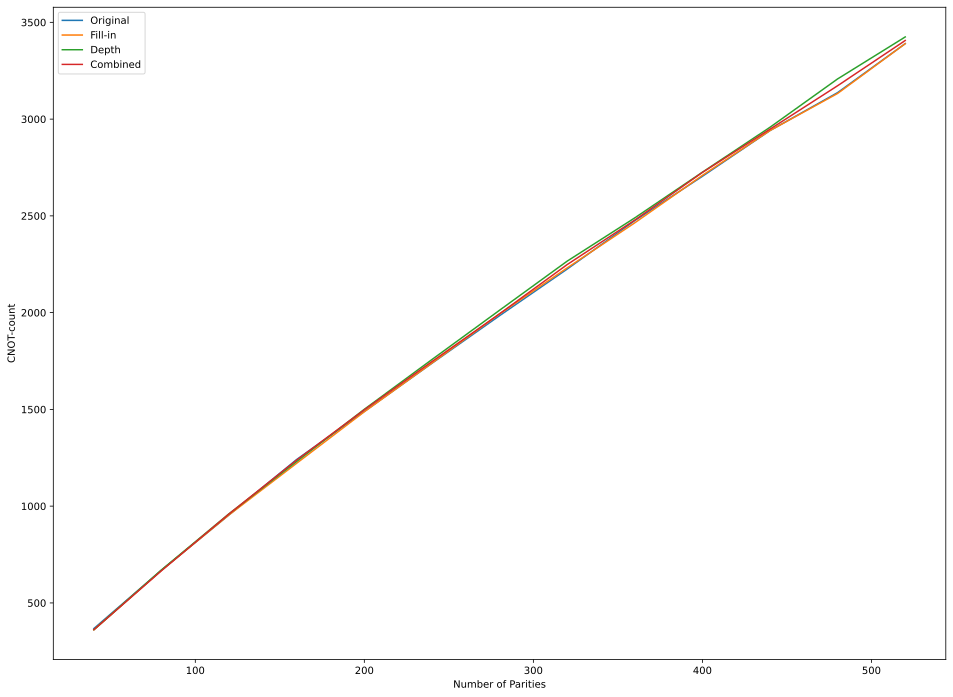

In [170]:
x = [40 *i for i in range(1,14)]
plt.figure(figsize=(16,12))
plt.plot(x,numGates, label = "Original")
plt.plot(x,numGates2, label = "Fill-in")
plt.plot(x,numGates3, label = "Depth")
plt.plot(x,numGates4, label = "Combined")
plt.xlabel("Number of Parities")
plt.ylabel("CNOT-count")
plt.legend()
plt.savefig('guadGates.pdf')
plt.show()

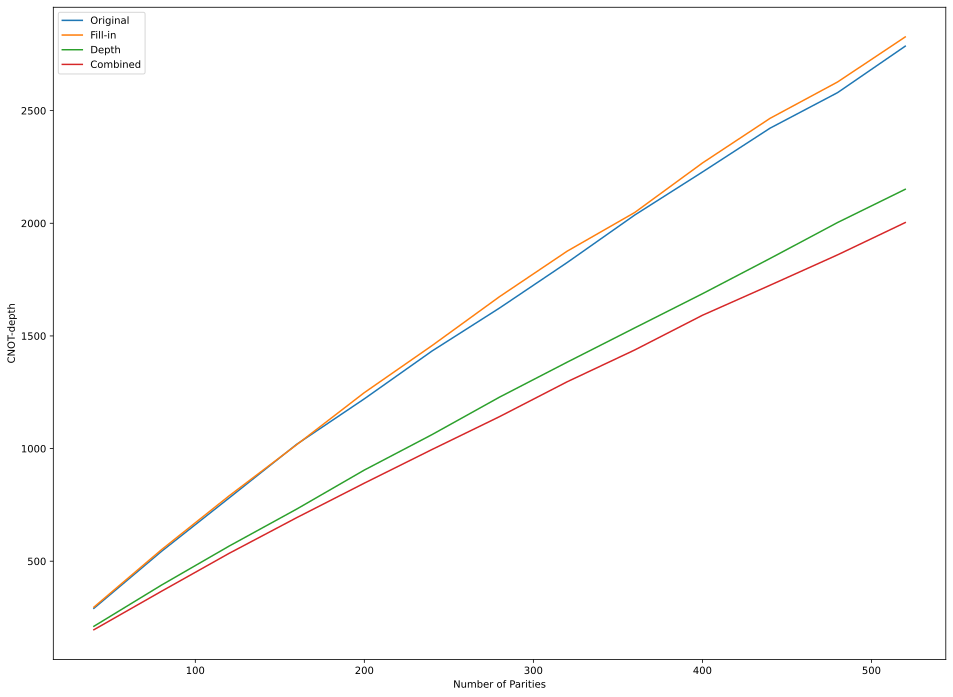

In [171]:
x = [40 *i for i in range(1,14)]
plt.figure(figsize=(16,12))
plt.plot(x,depthArr, label = "Original")
plt.plot(x,depthArr2, label = "Fill-in")
plt.plot(x,depthArr3, label = "Depth")
plt.plot(x,depthArr4, label = "Combined")
plt.xlabel("Number of Parities")
plt.ylabel("CNOT-depth")
plt.legend()
plt.savefig('guadDepth.pdf')
plt.show()

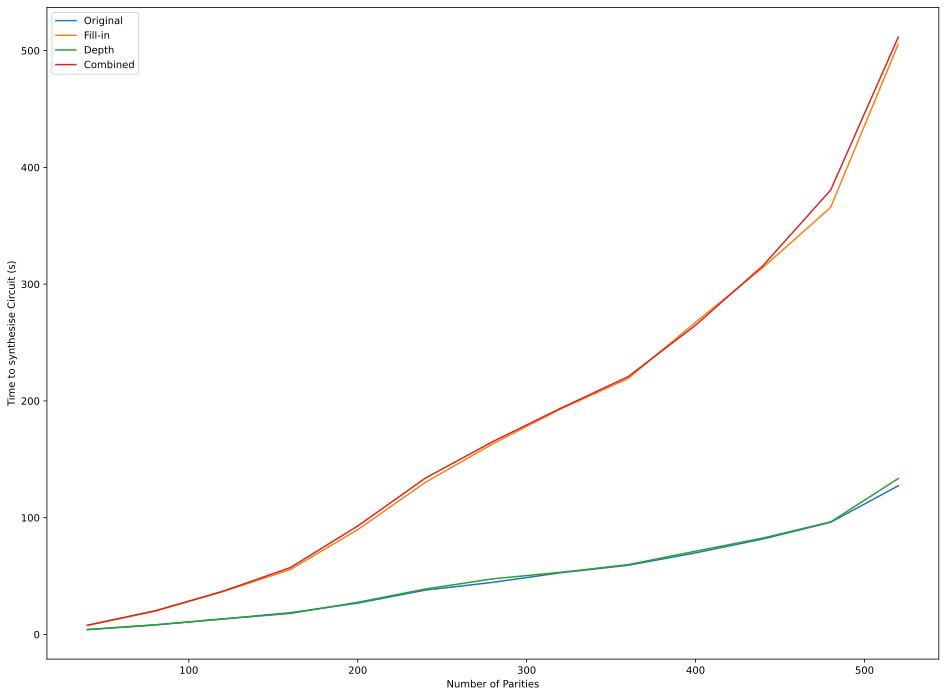

In [172]:
x = [40 *i for i in range(1,14)]
plt.figure(figsize=(16,12))
plt.plot(x,time1Arr, label = "Original")
plt.plot(x,time2Arr, label = "Fill-in")
plt.plot(x,time3Arr, label = "Depth")
plt.plot(x,time4Arr, label = "Combined")
plt.xlabel("Number of Parities")
plt.ylabel("Time to synthesise Circuit (s)")
plt.legend()
plt.savefig('guadTime.pdf')
plt.show()

In [90]:
g1 = np.array(numGates)
t1 = np.array(time1Arr)
d1 = np.array(depthArr)
g2 = np.array(numGates2)
t2 = np.array(time2Arr)
d2 = np.array(depthArr2)
g3 = np.array(numGates3)
t3 = np.array(time3Arr)
d3 = np.array(depthArr3)
g4 = np.array(numGates4)
t4 = np.array(time4Arr)
d4 = np.array(depthArr4)

In [82]:

np.save("gates1-circ",g1)
np.save("depth1-circ",d1)
np.save("time1-circ",t1)
np.save("gates2-circ",g2)
np.save("depth2-circ",d2)
np.save("time2-circ",t2)
np.save("gates3-circ",g3)
np.save("depth3-circ",d3)
np.save("time3-circ",t3)
np.save("gates4-circ",g4)
np.save("depth4-circ",d4)
np.save("time4-circ",t4)

In [89]:

np.save("gates1-GRID",g1)
np.save("depth1-GRID",d1)
np.save("time1-GRID",t1)
np.save("gates2-GRID",g2)
np.save("depth2-GRID",d2)
np.save("time2-GRID",t2)
np.save("gates3-GRID",g3)
np.save("depth3-GRID",d3)
np.save("time3-GRID",t3)
np.save("gates4-GRID",g4)
np.save("depth4-GRID",d4)
np.save("time4-GRID",t4)

In [74]:
g1 = np.array(numGates)
t1 = np.array(time1Arr)
d1 = np.array(depthArr)
g2 = np.array(numGates2)
t2 = np.array(time2Arr)
d2 = np.array(depthArr2)
g3 = np.array(numGates3)
t3 = np.array(time3Arr)
d3 = np.array(depthArr3)
g4 = np.array(numGates4)
t4 = np.array(time4Arr)
d4 = np.array(depthArr4)

In [75]:
np.save("gates1-melb",g1)
np.save("depth1-melb",d1)
np.save("time1-melb",t1)
np.save("gates2-melb",g2)
np.save("depth2-melb",d2)
np.save("time2-melb",t2)
np.save("gates3-melb",g3)
np.save("depth3-melb",d3)
np.save("time3-melb",t3)
np.save("gates4-melb",g4)
np.save("depth4-melb",d4)
np.save("time4-melb",t4)

In [68]:
g1 = np.array(numGates)
t1 = np.array(time1Arr)
d1 = np.array(depthArr)
g2 = np.array(numGates2)
t2 = np.array(time2Arr)
d2 = np.array(depthArr2)
g3 = np.array(numGates3)
t3 = np.array(time3Arr)
d3 = np.array(depthArr3)
g4 = np.array(numGates4)
t4 = np.array(time4Arr)
d4 = np.array(depthArr4)

In [69]:
np.save("gates1-GUAD",g1)
np.save("depth1-GUAD",d1)
np.save("time1-GUAD",t1)
np.save("gates2-GUAD",g2)
np.save("depth2-GUAD",d2)
np.save("time2-GUAD",t2)
np.save("gates3-GUAD",g3)
np.save("depth3-GUAD",d3)
np.save("time3-GUAD",t3)
np.save("gates4-GUAD",g4)
np.save("depth4-GUAD",d4)
np.save("time4-GUAD",t4)